In [72]:
from eeg_data_load import load_eeg_data
class_labels = [
    "Normal",
    "Complex_Partial_Seizures",
    "Electrographic_Seizures",
    "Video_detected_Seizures_with_no_visual_change_over_EEG",
]

train_noise_path = "/kaggle/input/eeg-data-final/EEG_Data/noisy_train_data"

In [86]:
X_train_noise, y_train_noise = load_eeg_data(train_noise_path, class_labels)

In [162]:
import numpy as np
import pandas as pd
import pywt
from scipy import stats
import numpy as np
import pywt
from scipy.signal import butter, filtfilt
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import warnings
warnings.filterwarnings("ignore")

In [163]:
X_train_noise.shape, y_train_noise.shape

((5608, 19, 500), (5608,))

In [165]:
class MultiChannelEEGDenoiser:
    def __init__(self, wavelet, level=5):
        self.wavelet = wavelet
        self.level = level

    def compute_threshold(self, coeff, level):
        """ Compute adaptive threshold based on the signal's noise level. """
        sigma = np.median(np.abs(coeff)) / 0.6745  # Median Absolute Deviation
        return sigma * np.sqrt(2 * np.log(len(coeff))) * (1 + level / self.level)

    def denoise_single_channel(self, signal):
        """ Denoise a single channel using wavelet decomposition and soft thresholding. """
        # Decompose signal using wavelet decomposition
        coeffs = pywt.wavedec(signal, self.wavelet, level=self.level)
        
        # Apply adaptive thresholding
        new_coeffs = list(coeffs)
        for i in range(1, len(coeffs)):  # Skip approximation coefficients
            threshold = self.compute_threshold(coeffs[i], i)
            new_coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
        
        # Reconstruct signal and handle edge effects
        denoised = pywt.waverec(new_coeffs, self.wavelet)
        return denoised[:len(signal)]

    def denoise_batch(self, data):
        """ Denoise a batch of multi-channel EEG data using parallel processing with a progress bar. """
        num_samples, num_channels, signal_length = data.shape
        denoised_data = np.zeros_like(data)
        total_channels = num_samples * num_channels

        # Progress bar for batch denoising
        with tqdm(total=total_channels, desc="Denoising channels", unit="channel", ncols=100, position=0) as pbar:
            with ThreadPoolExecutor() as executor:
                futures = []
                for i in range(num_samples):
                    for j in range(num_channels):
                        futures.append(executor.submit(self.denoise_single_channel, data[i, j]))
                
                # Collect results as they are completed
                for idx, future in enumerate(futures):
                    i, j = divmod(idx, num_channels)
                    denoised_data[i, j] = future.result()
                    pbar.update(1)

        return denoised_data


In [166]:
num_samples, num_channels, signal_length = X_train_noise.shape

# Initialize denoiser
denoiser = MultiChannelEEGDenoiser(wavelet='sym4', level=5)

# Denoise the EEG batch with parallel processing
denoised_data = denoiser.denoise_batch(X_train_noise)

Denoising channels: 100%|█████████████████████████████| 106552/106552 [02:26<00:00, 728.18channel/s]


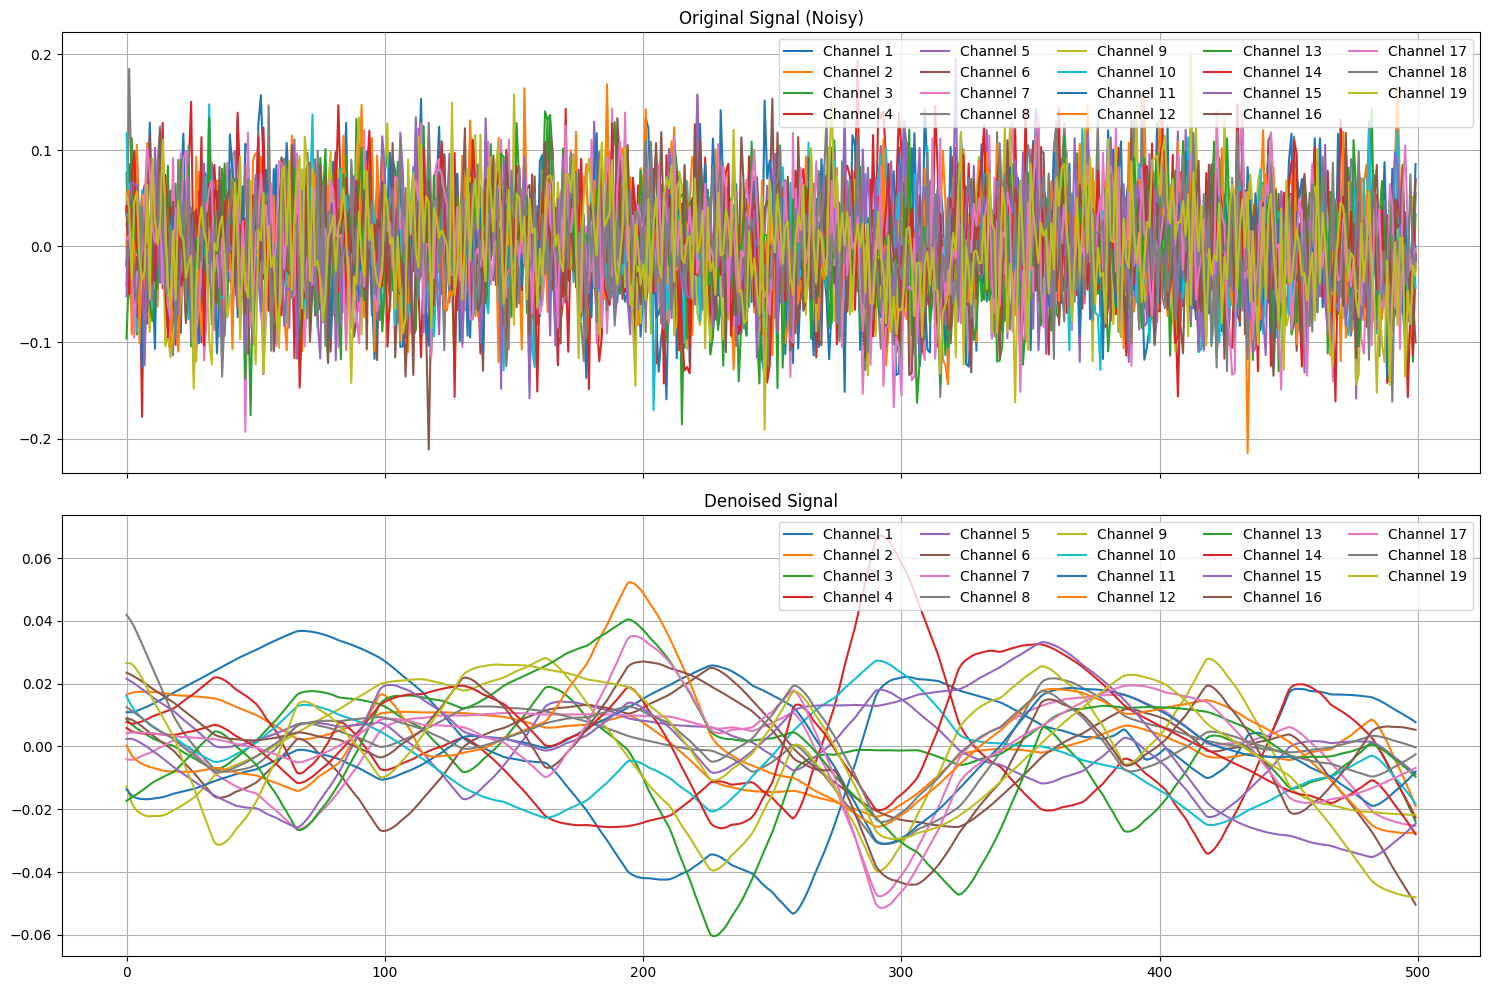

In [168]:
sample_index = 0
original_sample = X_train_noise[sample_index]
denoised_sample = denoised_data[sample_index]

num_channels = X_train_noise.shape[1]

# Plot the original and denoised signals for all channels in the selected sample
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Original signal
for channel in range(num_channels):
    axes[0].plot(original_sample[channel], label=f'Channel {channel + 1}')
axes[0].set_title("Original Signal (Noisy)")
axes[0].legend(ncol=5, loc='upper right')
axes[0].grid()

# Denoised signal
for channel in range(num_channels):
    axes[1].plot(denoised_sample[channel], label=f'Channel {channel + 1}')
axes[1].set_title("Denoised Signal")
axes[1].legend(ncol=5, loc='upper right')
axes[1].grid()

plt.tight_layout()
plt.show()

In [169]:
# Calculate PSNR for multi-channel EEG data
def calculate_psnr_eeg(original, denoised):
 
    if original.shape != denoised.shape:
        raise ValueError("Original and denoised arrays must have the same shape")
    
    num_samples, num_channels, _ = original.shape
    
    # Initialize arrays for storing PSNR values
    psnr_values = np.zeros((num_samples, num_channels))
    
    # Calculate PSNR for each sample and channel
    for i in range(num_samples):
        for j in range(num_channels):
            mse = np.mean((original[i, j] - denoised[i, j]) ** 2)
            if mse == 0:
                psnr_values[i, j] = float('inf')
            else:
                max_val = np.max(np.abs(original[i, j]))
                if max_val == 0:
                    psnr_values[i, j] = float('-inf')
                else:
                    psnr_values[i, j] = 20 * np.log10(max_val) - 10 * np.log10(mse)
    
    # Calculate statistics
    stats = {
        'mean_psnr': round(np.mean(psnr_values[psnr_values != float('inf')]), 2),
        'std_psnr': round(np.std(psnr_values[psnr_values != float('inf')]), 2),
        'min_psnr': round(np.min(psnr_values[psnr_values != float('inf')]), 2),
        'max_psnr': round(np.max(psnr_values[psnr_values != float('inf')]), 2),
        'per_channel_mean': np.round(np.mean(psnr_values, axis=0), 2),
        'per_sample_mean': np.round(np.mean(psnr_values, axis=1), 2)
    }
    
    return stats['mean_psnr'], stats

In [170]:
mean_psnr, stats = calculate_psnr_eeg(X_train_noise, denoised_data)

print(f"Overall mean PSNR: {mean_psnr:.2f} dB")
print("\nPer-channel mean PSNR:")
for ch, psnr in enumerate(stats['per_channel_mean'], 1):
    print(f"Channel {ch}: {psnr:.2f} dB")

print("\nPSNR Statistics:")
print(f"Min: {stats['min_psnr']:.2f} dB | Max: {stats['max_psnr']:.2f} dB | Std: {stats['std_psnr']:.2f} dB")

Overall mean PSNR: 10.62 dB

Per-channel mean PSNR:
Channel 1: 10.62 dB
Channel 2: 10.52 dB
Channel 3: 10.59 dB
Channel 4: 11.19 dB
Channel 5: 10.36 dB
Channel 6: 10.46 dB
Channel 7: 10.54 dB
Channel 8: 10.70 dB
Channel 9: 10.61 dB
Channel 10: 10.44 dB
Channel 11: 10.53 dB
Channel 12: 10.65 dB
Channel 13: 10.60 dB
Channel 14: 10.68 dB
Channel 15: 10.62 dB
Channel 16: 10.63 dB
Channel 17: 10.75 dB
Channel 18: 10.64 dB
Channel 19: 10.64 dB

PSNR Statistics:
Min: 7.36 dB | Max: 25.90 dB | Std: 1.28 dB


Training and evualating the model

In [187]:
from advanced_feature_extractor import EEGFeatureExtractor

extractor = EEGFeatureExtractor(denoised_data)
X_train_denoised = extractor.combine_features()

In [188]:
X_train_denoised.shape

(5608, 950)

In [189]:
np.save('X_train_denoised.npy',X_train_denoised)

In [220]:
X_val = np.load('/kaggle/input/features/X_val.npy')
y_val = np.load('/kaggle/input/features/y_val.npy')

In [221]:
X_train_tensor = torch.tensor(X_train_denoised, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_noise, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [222]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [254]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [272]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    # Check if CUDA is available on Kaggle and select the device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the model to the selected device (GPU or CPU)
    model = model.to(device)
    
    best_val_acc = 0
    best_model = None
    training_losses = []
    validation_losses = []
    
    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            epoch_train_loss = 0
            
            train_loader_tqdm = tqdm(train_loader, 
                                   desc=f"Epoch {epoch+1}/{num_epochs} - Training",
                                   leave=False,  # Don't leave the progress bar
                                   position=0,   # Fix the position
                                   ncols=100)    # Fix the width
            
            for inputs, labels in train_loader_tqdm:
                # Move inputs and labels to the GPU (or CPU if no GPU is available)
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item()
                train_loader_tqdm.set_postfix({'loss': f'{loss.item():.4f}'}, refresh=True)
            
            avg_train_loss = epoch_train_loss / len(train_loader)
            training_losses.append(avg_train_loss)
            
            # Validation phase
            model.eval()
            epoch_val_loss = 0
            val_preds = []
            val_labels = []
            
            with torch.no_grad():
                val_loader_tqdm = tqdm(val_loader, 
                                     desc=f"Epoch {epoch+1}/{num_epochs} - Validation",
                                     leave=False,  # Don't leave the progress bar
                                     position=0,   # Fix the position
                                     ncols=100)    # Fix the width
                
                for inputs, labels in val_loader_tqdm:
                    # Move inputs and labels to the GPU (or CPU if no GPU is available)
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())
                    val_loader_tqdm.set_postfix({'loss': f'{loss.item():.4f}'}, refresh=True)
            
            avg_val_loss = epoch_val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            
            # Print epoch summary on a new line
            val_acc = balanced_accuracy_score(val_labels, val_preds)
            print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}')
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model.state_dict().copy()
                print(f'New best model saved with validation accuracy: {val_acc:.4f}')
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Saving best model...")
    
    finally:
        # Plot training curves
        plt.figure(figsize=(10, 6))
        plt.plot(training_losses, label='Training Loss')
        plt.plot(validation_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        if best_model is not None:
            model.load_state_dict(best_model)
    
    return model, training_losses, validation_losses



In [273]:
from model_utility_script import EEGClassifier

input_size = X_train_denoised.shape[1]
model = EEGClassifier(input_size=input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1: Train Loss = 0.6231, Val Loss = 0.4782, Val Acc = 0.6454
New best model saved with validation accuracy: 0.6454


Epoch 2: Train Loss = 0.4625, Val Loss = 0.4715, Val Acc = 0.7255
New best model saved with validation accuracy: 0.7255


Epoch 3: Train Loss = 0.3953, Val Loss = 0.5302, Val Acc = 0.7142


Epoch 4: Train Loss = 0.3632, Val Loss = 0.3863, Val Acc = 0.7628
New best model saved with validation accuracy: 0.7628


Epoch 5: Train Loss = 0.3265, Val Loss = 0.4150, Val Acc = 0.7413


Epoch 6: Train Loss = 0.3101, Val Loss = 0.4365, Val Acc = 0.7521


Epoch 7: Train Loss = 0.2607, Val Loss = 0.4284, Val Acc = 0.7275


Epoch 8: Train Loss = 0.2581, Val Loss = 0.4313, Val Acc = 0.7058


Epoch 9: Train Loss = 0.2479, Val Loss = 0.3595, Val Acc = 0.7835
New best model saved with validation accuracy: 0.7835


Epoch 10: Train Loss = 0.2174, Val Loss = 0.4336, Val Acc = 0.7728


Epoch 11: Train Loss = 0.1950, Val Loss = 0.5499, Val Acc = 0.7611


Epoch 12: Train Loss = 0.1753, Val Loss = 0.4593, Val Acc = 0.7584


Epoch 13: Train Loss = 0.1695, Val Loss = 0.4988, Val Acc = 0.7604


Epoch 14: Train Loss = 0.1649, Val Loss = 0.5426, Val Acc = 0.7499


Epoch 15: Train Loss = 0.1551, Val Loss = 0.4547, Val Acc = 0.8075
New best model saved with validation accuracy: 0.8075


Epoch 16: Train Loss = 0.1221, Val Loss = 0.4504, Val Acc = 0.8359
New best model saved with validation accuracy: 0.8359


Epoch 17: Train Loss = 0.1086, Val Loss = 0.5034, Val Acc = 0.7880


Epoch 18: Train Loss = 0.1062, Val Loss = 0.5069, Val Acc = 0.7699


Epoch 19: Train Loss = 0.0879, Val Loss = 0.5755, Val Acc = 0.7650


Epoch 20: Train Loss = 0.0976, Val Loss = 0.5612, Val Acc = 0.7546


Epoch 21: Train Loss = 0.0701, Val Loss = 0.6039, Val Acc = 0.7653


Epoch 22: Train Loss = 0.0831, Val Loss = 0.6193, Val Acc = 0.7683


Epoch 23: Train Loss = 0.0848, Val Loss = 0.6940, Val Acc = 0.7149


Epoch 24: Train Loss = 0.0700, Val Loss = 0.5947, Val Acc = 0.7771


Epoch 25: Train Loss = 0.0675, Val Loss = 0.7903, Val Acc = 0.7717


Epoch 26: Train Loss = 0.0612, Val Loss = 0.8576, Val Acc = 0.7613


Epoch 27: Train Loss = 0.0638, Val Loss = 0.6270, Val Acc = 0.7706


Epoch 28: Train Loss = 0.0527, Val Loss = 0.6888, Val Acc = 0.7514


Epoch 29: Train Loss = 0.0691, Val Loss = 0.9654, Val Acc = 0.7420


Epoch 30: Train Loss = 0.0615, Val Loss = 0.7639, Val Acc = 0.7612


Epoch 31: Train Loss = 0.0598, Val Loss = 0.5747, Val Acc = 0.7614


Epoch 32: Train Loss = 0.0402, Val Loss = 0.6234, Val Acc = 0.7961


Epoch 33: Train Loss = 0.0413, Val Loss = 0.6993, Val Acc = 0.7514


Epoch 34: Train Loss = 0.0505, Val Loss = 0.5494, Val Acc = 0.8755
New best model saved with validation accuracy: 0.8755


Epoch 35: Train Loss = 0.0439, Val Loss = 0.5850, Val Acc = 0.8611


Epoch 36: Train Loss = 0.0371, Val Loss = 0.5790, Val Acc = 0.8695


Epoch 37: Train Loss = 0.0484, Val Loss = 0.6776, Val Acc = 0.7636


Epoch 38: Train Loss = 0.0354, Val Loss = 0.6876, Val Acc = 0.7797


Epoch 39: Train Loss = 0.0329, Val Loss = 0.6912, Val Acc = 0.7608


Epoch 40: Train Loss = 0.0384, Val Loss = 0.5371, Val Acc = 0.7854


Epoch 41: Train Loss = 0.0275, Val Loss = 0.6889, Val Acc = 0.7892


Epoch 42: Train Loss = 0.0320, Val Loss = 0.7418, Val Acc = 0.7410


Epoch 43: Train Loss = 0.0345, Val Loss = 0.7804, Val Acc = 0.7635


Epoch 44: Train Loss = 0.0320, Val Loss = 0.7853, Val Acc = 0.7757


Epoch 45: Train Loss = 0.0210, Val Loss = 0.7220, Val Acc = 0.7533


Epoch 46: Train Loss = 0.0475, Val Loss = 0.7149, Val Acc = 0.7240


Epoch 47: Train Loss = 0.0448, Val Loss = 0.6890, Val Acc = 0.7455


Epoch 48: Train Loss = 0.0414, Val Loss = 0.6551, Val Acc = 0.7557


Epoch 49: Train Loss = 0.0209, Val Loss = 0.6316, Val Acc = 0.7537


Epoch 50: Train Loss = 0.0233, Val Loss = 0.6496, Val Acc = 0.8857
New best model saved with validation accuracy: 0.8857


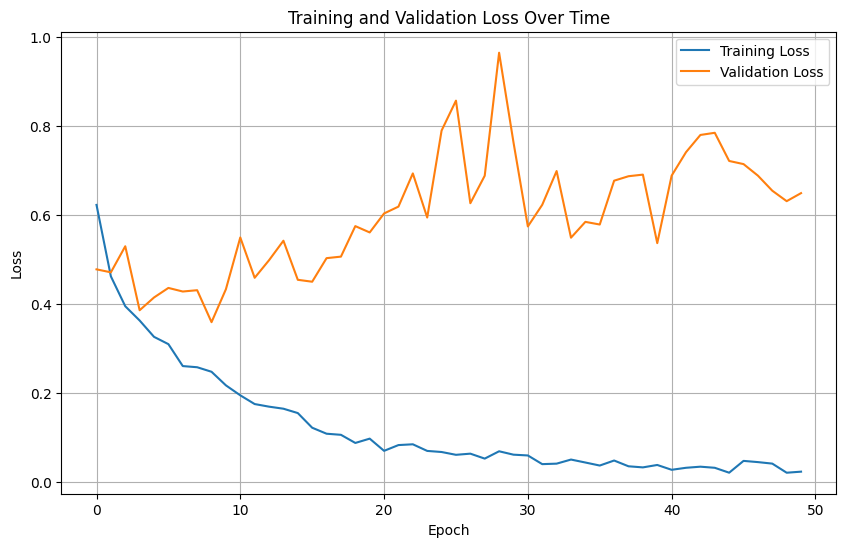

In [274]:
model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer)

In [275]:
def evaluate_model(model, test_loader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] 
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Get predictions and probabilities
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)
            
            # Collect the results
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate the classification report and balanced accuracy
    classification_report_result = classification_report(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    
    # Compute the AUC-ROC score for multi-class classification (One-vs-Rest)
    auc_roc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='macro')

    # Print the outputs
    print("Classification Report:\n", classification_report_result)
    print("Balanced Accuracy:", balanced_accuracy)
    print("AUC-ROC Score:", auc_roc)
    
    return {
        'classification_report': classification_report_result,
        'balanced_accuracy': balanced_accuracy,
        'auc_roc': auc_roc
    }

# Example usage
results = evaluate_model(model, val_loader, num_classes=4)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       696
           1       0.86      0.87      0.86       549
           2       0.77      0.96      0.85       137
           3       0.95      0.86      0.90        21

    accuracy                           0.87      1403
   macro avg       0.87      0.89      0.87      1403
weighted avg       0.87      0.87      0.87      1403

Balanced Accuracy: 0.8856661490234728
AUC-ROC Score: 0.9734224392252697
